In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from os import listdir
from os.path import isfile, isdir
from scipy.stats import ttest_ind
import sys

from ReplicaMetropolis.run.utils import load_parameters as load_replica_parameters
from ReplicaMetropolis.run.utils import load_all as load_replica_data
from Quench.run.utils import load_all as load_quench

In [2]:
plt.rcParams.update({'font.size': 13})
protein_name = '1PGB'

In [3]:
def calculate_Haming_distance(sequence_a, sequence_b):
    array_a = np.array(list(sequence_a))
    array_b = np.array(list(sequence_b))
    new_residues_idxs = np.where(array_a != array_b)[0]
    Hamm_distance = len(new_residues_idxs)
    return Hamm_distance

---
### PFAM alignement K-sites combinations

In [4]:
site_weights = np.load('Quench/run/inputs/site_weights.npy')
mask = site_weights == 1.
num_Ksites = mask.sum().astype(int)
d_start = f'results/{protein_name}'

with open(f'Quench/results/{protein_name}/{protein_name}_alignement.txt', 'r') as f:
    lines = f.readlines()
alignement = [line.split('\t')[-1][:-1] for line in lines]
Ksites_alignement = [''.join(np.array(list(sequence))[mask]) for sequence in alignement if not '-' in sequence]
Ksites_alignement, alignement_counts = np.unique(Ksites_alignement, return_counts = True)
wt_index = np.argmax(alignement_counts)

print('PFAM alignement K-sites combinations and frequencies:\n')
for idx, (Ksites, count) in enumerate(zip(Ksites_alignement, alignement_counts)):
    if idx == wt_index: suffix = '(1PGB)'
    else: suffix = ''
    print(f'{Ksites}\t\t{format(100 * count/alignement_counts.sum(), ".1f")}%\t{suffix}')
print()

PFAM alignement K-sites combinations and frequencies:

FGAFFWA		0.9%	
FGAFLWA		1.8%	
FGAFLWG		0.9%	
FIAFAFY		1.8%	
FIAFLYY		1.8%	
LGAFFWA		2.6%	
LGAFGWV		81.6%	(1PGB)
LGAFLWA		6.1%	
LIAFLWA		1.8%	
LIAFLWV		0.9%	



---
### Directories

##### - Replica

In [9]:
y = 5
gm_comb = 2

d_start = f'ReplicaMetropolis/results/{protein_name}/gm{gm_comb}'
raw_dirlist = np.array([f'{d_start}/{d}' for d in listdir(f'{d_start}') if isdir(f'{d_start}/{d}') and (not '.ipynb' in d)])
seeds = np.array([int(d.split('/')[-1].split('_')[1][1:]) for d in raw_dirlist])
sort_seeds = np.sort(seeds)
sort_dirlist = [raw_dirlist[seeds == seed][0] for seed in sort_seeds]

replica_shown_seeds = [0, 2]
replica_bad_seeds = [6, 7]
replica_dirlist = [str(d) for seed, d in zip(sort_seeds, sort_dirlist) if not seed in replica_bad_seeds]

##### - Quench

In [6]:
d_start = f'Quench/results/{protein_name}'
raw_dirlist = np.array([f'{d_start}/{d}' for d in listdir(f'{d_start}') if isdir(f'{d_start}/{d}') and (not '.ipynb' in d)])
seeds = np.array([int(d.split('/')[-1][1:]) for d in raw_dirlist])
sort_seeds = np.sort(seeds)
sort_dirlist = [raw_dirlist[seeds == seed][0] for seed in sort_seeds]

quench_shown_seeds = [-2, -4]
quench_bad_seeds = []
quench_dirlist = [str(d) for seed, d in zip(sort_seeds, sort_dirlist) if not seed in quench_bad_seeds]

---
### Plot

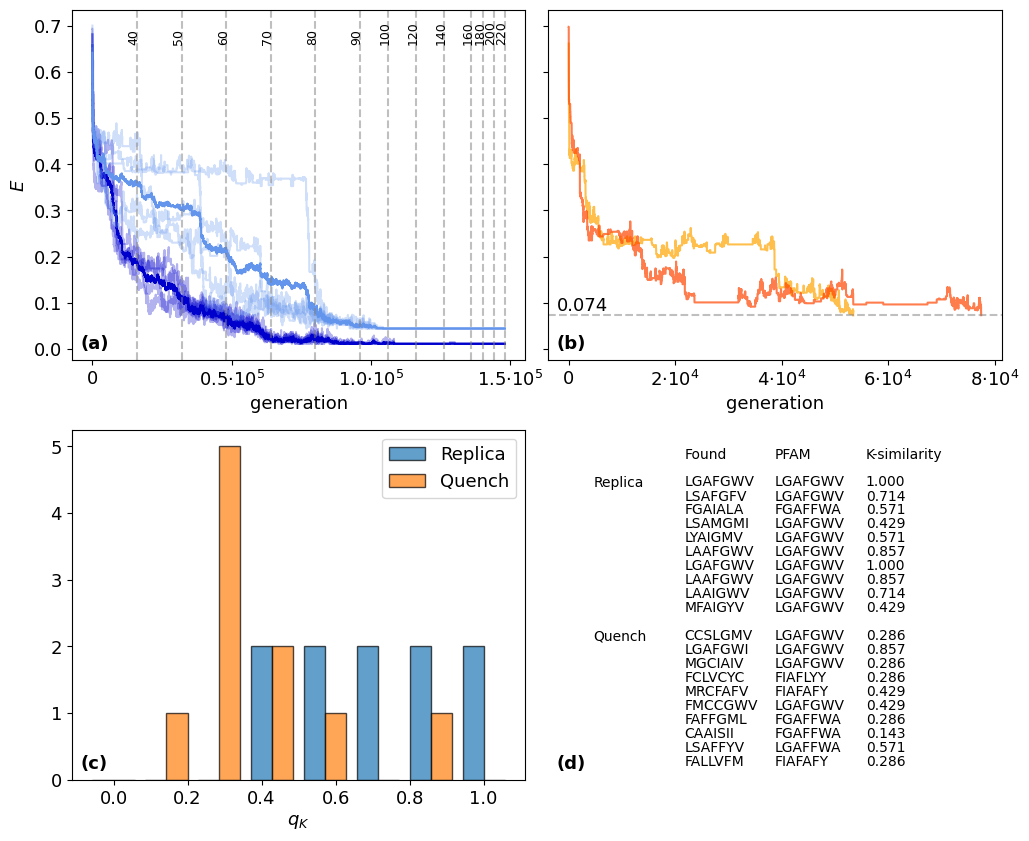

In [13]:
fig, ((rax, qax), (hax, wax)) = plt.subplots(figsize = (12, 10), nrows = 2, ncols = 2)
index_x, index_y = 0.05, 0.02


#########
# Replica
#########
ax = rax
icolor = 0
colors = ['mediumblue', 'cornflowerblue']
replica_qK, replica_Ksites, replica_Ksim = [], [], []
for id, d in enumerate(replica_dirlist):
    parameters = load_replica_parameters(d)  
    data = load_replica_data(str(d)) 
    generations = parameters['generation']
    seed = np.unique(parameters['seed'])

    ## Data plotting
    if seed in replica_shown_seeds:
        for irep in range(y):
            ax.plot(generations/y, data['energies'][:, irep], color = colors[icolor], alpha = 0.3)
        ax.plot(generations/y, data['energies'].mean(axis = 1), color = colors[icolor])
        icolor += 1

    ## Sequences K-sites
    gammas = parameters['gamma']
    hg_sequences, hg_counts = np.unique(data['sequences'][gammas == gammas.max()].reshape(-1), return_counts = True)
    hg_sequence = hg_sequences[hg_counts.argmax()]
    Ksites_hg_sequence = np.array([''.join(np.array(list(hg_sequence))[mask])])[0]
    
    alignement_distances = []
    for Ksites in Ksites_alignement:
        distance = calculate_Haming_distance(Ksites_hg_sequence, Ksites)
        alignement_distances.append(distance)
    qK = (num_Ksites - np.min(alignement_distances)) / num_Ksites
    most_sim_Ksites = Ksites_alignement[np.argmin(alignement_distances)]

    replica_qK.append(qK)
    replica_Ksites.append(Ksites_hg_sequence)
    replica_Ksim.append(most_sim_Ksites)

ax.set_ylabel(r'$E$')
ax.set_xlabel('generation')
#ax.ticklabel_format(axis = 'x', style = 'sci', scilimits = (5, 5))
ax.set_xticks([0, 50_000, 100_000, 150_000])
ax.set_xticklabels([r'0', r'0.5$\cdot$10$^{5}$', r'1.0$\cdot$10$^{5}$', r'1.5$\cdot$10$^{5}$'])
ylim = ax.get_ylim() 

with open(f'{replica_dirlist[0]}/gmfile.txt', 'r') as f:
    lines = f.readlines()
generation = 0
for line in lines:
    gamma, mutations = float(line.split('\t')[0]), int(line.split('\t')[1])
    generation += mutations
    ylow, yspan = ax.get_ylim()[0], np.diff(ax.get_ylim())[0]
    height = ylow + yspan * 0.9
    ax.axvline(generation/y, linestyle = '--', color = 'grey', alpha = 0.5)
    ax.annotate(f'{int(gamma)}',
                xy=(generation/y, height),
                xytext=(-2, 0),
                rotation=90,
                textcoords='offset points',
                ha='center', va='bottom', 
                fontsize = 9
    )

xlow, xspan = ax.get_xlim()[0], np.diff(ax.get_xlim())[0]
ylow, yspan = ax.get_ylim()[0], np.diff(ax.get_ylim())[0]
ax.annotate('(a)',
            xy=(xlow+xspan*index_x, ylow+yspan*index_y),
            xytext=(0, 0),
            rotation=0,
            textcoords='offset points',
            ha='center', va='bottom',
            fontsize = 13,
            weight = 'bold'
)


########
# Quench
########
ax = qax
icolor = 0
colors = ['orange', 'orangered']
quench_qK, quench_Ksites, quench_Ksim = [], [], []
for id, d in enumerate(quench_dirlist):
    data, parameters = load_quench(d) 
    generations = parameters['generation']
    seed = np.unique(parameters['seed'])

    ## Data plotting
    if seed in quench_shown_seeds:
        ax.plot(generations, data['energies'], color = colors[icolor], alpha = 0.7)
        icolor += 1

    ## Sequences K-sites
    last_sequence = data['sequences'][-1]
    Ksites_last_sequence= np.array([''.join(np.array(list(last_sequence))[mask])])[0]

    alignement_distances = []
    for Ksites in Ksites_alignement:
        distance = calculate_Haming_distance(Ksites_last_sequence, Ksites)
        alignement_distances.append(distance)
    qK = (num_Ksites - np.min(alignement_distances)) / num_Ksites
    most_sim_Ksites = Ksites_alignement[np.argmin(alignement_distances)]

    quench_qK.append(qK)
    quench_Ksites.append(Ksites_last_sequence)
    quench_Ksim.append(most_sim_Ksites)
    
ax.set_xlabel(r'generation')
#ax.ticklabel_format(axis = 'x', style = 'sci', scilimits = (4, 4))
ax.set_xticks([0, 20_000, 40_000, 60_000, 80_000])
ax.set_xticklabels([r'0', r'2$\cdot$10$^{4}$', r'4$\cdot$10$^{4}$', r'6$\cdot$10$^{4}$', r'8$\cdot$10$^{4}$'])
ax.set_yticklabels([])
ax.set_ylim(ylim)

with open(f'{quench_dirlist[0]}/Tgt_file.txt', 'r') as f:
    lines = f.readlines()
assert len(lines) == 1, f'Unexpected number of lines for quench algorithm. Expected 1, Found {len(lines)}.'
T, gamma, threshold = float(lines[0].split('\t')[0]), float(lines[0].split('\t')[1]), float(lines[0].split('\t')[2])
ax.axhline(threshold, linestyle = '--', color = 'grey', alpha = 0.5)
ax.annotate(format(threshold, ".3f"),
            xy=(0, threshold),
            xytext=(10, 0),
            rotation=0,
            textcoords='offset points',
            ha='center', va='bottom',
            fontsize = 13
)

xlow, xspan = ax.get_xlim()[0], np.diff(ax.get_xlim())[0]
ylow, yspan = ax.get_ylim()[0], np.diff(ax.get_ylim())[0]
ax.annotate('(b)',
            xy=(xlow+xspan*index_x, ylow+yspan*index_y),
            xytext=(0, 0),
            rotation=0,
            textcoords='offset points',
            ha='center', va='bottom',
            fontsize = 13,
            weight = 'bold'
)


###########
# Histogram
###########
ax = hax
numKsites = mask.astype(int).sum()
bins = np.linspace(0., 1. + 1./numKsites, numKsites + 2) - 1./numKsites/2.
ax.hist([replica_qK, quench_qK], bins = bins, density = False, histtype = 'bar', 
        edgecolor = 'black', alpha = 0.7, label = ['Replica', 'Quench'])
ax.set_xlabel(r'$q_K$')
ax.legend(loc = 'upper right')

xlow, xspan = ax.get_xlim()[0], np.diff(ax.get_xlim())[0]
ylow, yspan = ax.get_ylim()[0], np.diff(ax.get_ylim())[0]
ax.annotate('(c)',
            xy=(xlow+xspan*index_x, ylow+yspan*index_y),
            xytext=(0, 0),
            rotation=0,
            textcoords='offset points',
            ha='center', va='bottom',
            fontsize = 13,
            weight = 'bold'
)


#############
# Annotations
#############
ax = wax
ax.axis('off')
downshift = -0.05
rightshift = 0.1

annotations = ['Found', 'PFAM', r'K-similarity']
for iann, annotation in enumerate(annotations):
    ax.annotate(annotation,
                xy=(rightshift + (iann+1) * 0.2, 1.-(1./25.) + downshift),
                xytext=(0, 0),
                rotation=0,
                textcoords='offset points',
                ha='left', va='bottom',
                fontsize = 10
    )

annotations = ['Replica', 'Quench']
for iann, annotation in enumerate(annotations):
    ax.annotate(annotation,
                xy=(rightshift, 1.-(3 + iann*11)/25. + downshift),
                xytext=(0, 0),
                rotation=0,
                textcoords='offset points',
                ha='left', va='bottom',
                fontsize = 10
    )

for id, (qK, Ksites, Ksim) in enumerate(zip(replica_qK, replica_Ksites, replica_Ksim)):
    annotations = [Ksites, Ksim, format(qK, ".3f")]
    for iann, annotation in enumerate(annotations):
        ax.annotate(annotation,
                    xy=(rightshift + (iann+1) * 0.2, 1.-(id + 3)/25. + downshift),
                    xytext=(0, 0),
                    rotation=0,
                    textcoords='offset points',
                    ha='left', va='bottom',
                    fontsize = 10
        )

for id, (qK, Ksites, Ksim) in enumerate(zip(quench_qK, quench_Ksites, quench_Ksim)):
    annotations = [Ksites, Ksim, format(qK, ".3f")]
    for iann, annotation in enumerate(annotations):
        ax.annotate(annotation,
                    xy=(rightshift + (iann+1) * 0.2, 1.-(id + 14)/25. + downshift),
                    xytext=(0, 0),
                    rotation=0,
                    textcoords='offset points',
                    ha='left', va='bottom',
                    fontsize = 10
        )

xlow, xspan = ax.get_xlim()[0], np.diff(ax.get_xlim())[0]
ylow, yspan = ax.get_ylim()[0], np.diff(ax.get_ylim())[0]
ax.annotate('(d)',
            xy=(xlow+xspan*index_x, ylow+yspan*index_y),
            xytext=(0, 0),
            rotation=0,
            textcoords='offset points',
            ha='center', va='bottom',
            fontsize = 13,
            weight = 'bold'
)


plt.subplots_adjust(wspace = 0.05)
plt.savefig(f'plots/Quench_Replica_comparison.png', bbox_inches='tight');